# Forest Fire Incidence in Northern Algeria: Report

In [29]:
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 8)

In [30]:
set.seed(1)

## Introduction

Algeria is considered to be semi-arid, with only 0.82% of its land covered by forest (Aini et. al., 2019). This forest is concentrated along the northern Mediterranean coast of the country, and is characterized by vast coverage of shrublands and forests, and a humid climate (Curt et. al., 2020). The northern region of Algeria is also characterized by high wildfire activity, experiencing 32 204 incidents and burning a total of 16 954 km^2 of area between 2001 and 2019 (Curt et. al., 2020). Most of the fires occur in the summer months, after the intense rainfalls of the spring and fall that promote lush vegetation growth (Curt et. al., 2020). Past studies have suggested that the principal causation for fire activity is the combination of abundant vegetation and dry, warm weather of the summer; however, there are also links to agricultural activities, as farmers usually ignite fires in the summer to manage vegetation in cultivated lands (Aini et. al., 2019).

The dataset we will use in this analysis includes daily temperature, relative humidity, rainfall, wind speed, and Fire Weather Index (FWI) data collected in the Bejaia and Sidi Bel Abbes regions of Northern Algeria from June 1st to September 30th in 2012 (Faroudja ABID et. al., 2019). FWI is divided into two categories (De Groot, 1987). Fuel moisture codes (FFMC, DMC, and DC) represent ratings of moisture for specific fuel depths. Fire behaviour indices include Initial Spread Index (ISI), the expected rate of fire spread, Buildup Index (BUI), the amount of fuel available, and Fire Weather Index, the expected fire intensity. 122 observations were recorded for each of the regions.

Through this data analysis, our goal is to answer the following question: Can we predict whether the Bejaia or Sidi Bel Abbes regions in Algeria will experience a forest fire based upon bioclimatic conditions?



## Methods

In [56]:
## Load datasets from URL

algerian_forest_fire_Bejaia <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                 skip = 1, n_max = 122) 

algerian_forest_fire_Sidi_Bel_Abbes <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                                               skip = 126)

## Merge datasets of the two regions

algeria_forest_fire_all_data <- rbind(algerian_forest_fire_Bejaia, algerian_forest_fire_Sidi_Bel_Abbes) %>%
    mutate(Classes = as_factor(Classes)) 

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

In [57]:
## Manually set values of incorrect column, convert DC and FWI to numeric type

algeria_forest_fire_all_data[166, 10] <- '14.6'
algeria_forest_fire_all_data[166, 11] <- 9
algeria_forest_fire_all_data[166, 12] <- 12.5
algeria_forest_fire_all_data[166, 13] <- '10.4'
algeria_forest_fire_all_data[166, 14] <- "fire" 

algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))


In [70]:
## Create training dataset

forest_fire_split <- algeria_forest_fire_all_data %>%
    initial_split(prop = 0.75, strata = Classes)
forest_fire_train <- training(forest_fire_split)
forest_fire_test <- testing(forest_fire_split)

head(forest_fire_train)

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
06,06,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire
07,06,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire
08,06,2012,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire


*Table 1: The first six observations in the training dataset to be used for building the classifcation model*

To begin the analysis, the Algerian Forest Fires Dataset was loaded from the UC Irvine Machine Learning Repository. The dataset contained two different tables for data collected in the Bejaia and Sidi Bel Abbes regions. As such, the tables were loaded into separate dataframes by the “read_csv” function, using the “skip” and “n_max” arguments to isolate each table from the file, and then combined. The “Classes” variable was changed into the factor datatype for use in classification algorithms. After an initial look through the combined dataframe, it was noticed that an observation in the Sidi Bel Abbes region had incorrect variable assignments resulting from a missing comma in the .csv file. To address this error, the affected cells were manually reassigned. The incorrect variable assignments also resulted in the “DC” and “FWI'' variables to be incorrectly cast into the character datatype. These columns were reassigned to the correct numeric datatype using the “as.numeric” function within “mutate.”

Subsequently, the data was split into training and testing sets. It is suggested that between 50% - 100% of the data is used for training classification models. Because the dataset is limited in size, it was important that enough data was included in the training set to build a robust model, but also, that enough data was included in the testing set to make a reliable assessment of the model’s accuracy. A 75% split of the data was decided based upon the aforementioned criteria.


### Exploratory Data Analysis

The classification algorithm to be used for the analysis is the k-nearest neighbours algorithm. However, this algorithm performs poorly when there are many predictor variables; therefore, it was necessary to choose only several variables from the available ten of the dataset through an exploratory analysis. The training dataset was used for this exploratory analysis, to ensure that the testing data was not introducing any bias into the results. 

To identify the best predictors, we compared the distribution of the variables in the dataset between the 2 classes, examining differences which might suggest how each variable relates to fire incidence.

In [59]:
temp_distribution <- ggplot(forest_fire_train, aes(x = Temperature)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Temperature (C)", y = "Frequency", title = "Temperature") +
    theme(text = element_text(size = 20))

In [60]:
RH_distribution <- ggplot(forest_fire_train, aes(x = RH)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Relative Humidity (%)", y = "Frequency", title = "Relative Humidity") +
    theme(text = element_text(size = 20))

In [61]:
WS_distribution <- ggplot(forest_fire_train, aes(x = RH)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Wind Speed (km/h)", y = "Frequency", title = "Wind Speed") +
    theme(text = element_text(size = 20))

In [62]:
rain_distribution <- ggplot(forest_fire_train, aes(x = Rain)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Rainfall (mm, daily)", y = "Frequency", title = "Rainfall") +
    theme(text = element_text(size = 20))

In [63]:
FFMC_distribution <- ggplot(forest_fire_train, aes(x = FFMC)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Frequency", title = "FFMC") +
    theme(text = element_text(size = 20))

In [64]:
DMC_distribution <- ggplot(forest_fire_train, aes(x = DMC)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Duff Moisture Code (DMC)", y = "Frequency", title = "DMC") +
    theme(text = element_text(size = 20))

In [65]:
DC_distribution <- ggplot(forest_fire_train, aes(x = DC)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Drought Code (DC)", y = "Frequency", title = "DC") +
    theme(text = element_text(size = 20))

In [66]:
ISI_distribution <- ggplot(forest_fire_train, aes(x = ISI)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Initial Spread Index (ISI)", y = "Frequency", title = "ISI") +
    theme(text = element_text(size = 20))

In [67]:
BUI_distribution <- ggplot(forest_fire_train, aes(x = BUI)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Buildup Index (BUI)", y = "Frequency", title = "BUI") +
    theme(text = element_text(size = 20))

In [68]:
FWI_distribution <- ggplot(forest_fire_train, aes(x = FWI)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Fire Weather Index (FWI)", y = "Frequency", title = "FWI") +
    theme(text = element_text(size = 20))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



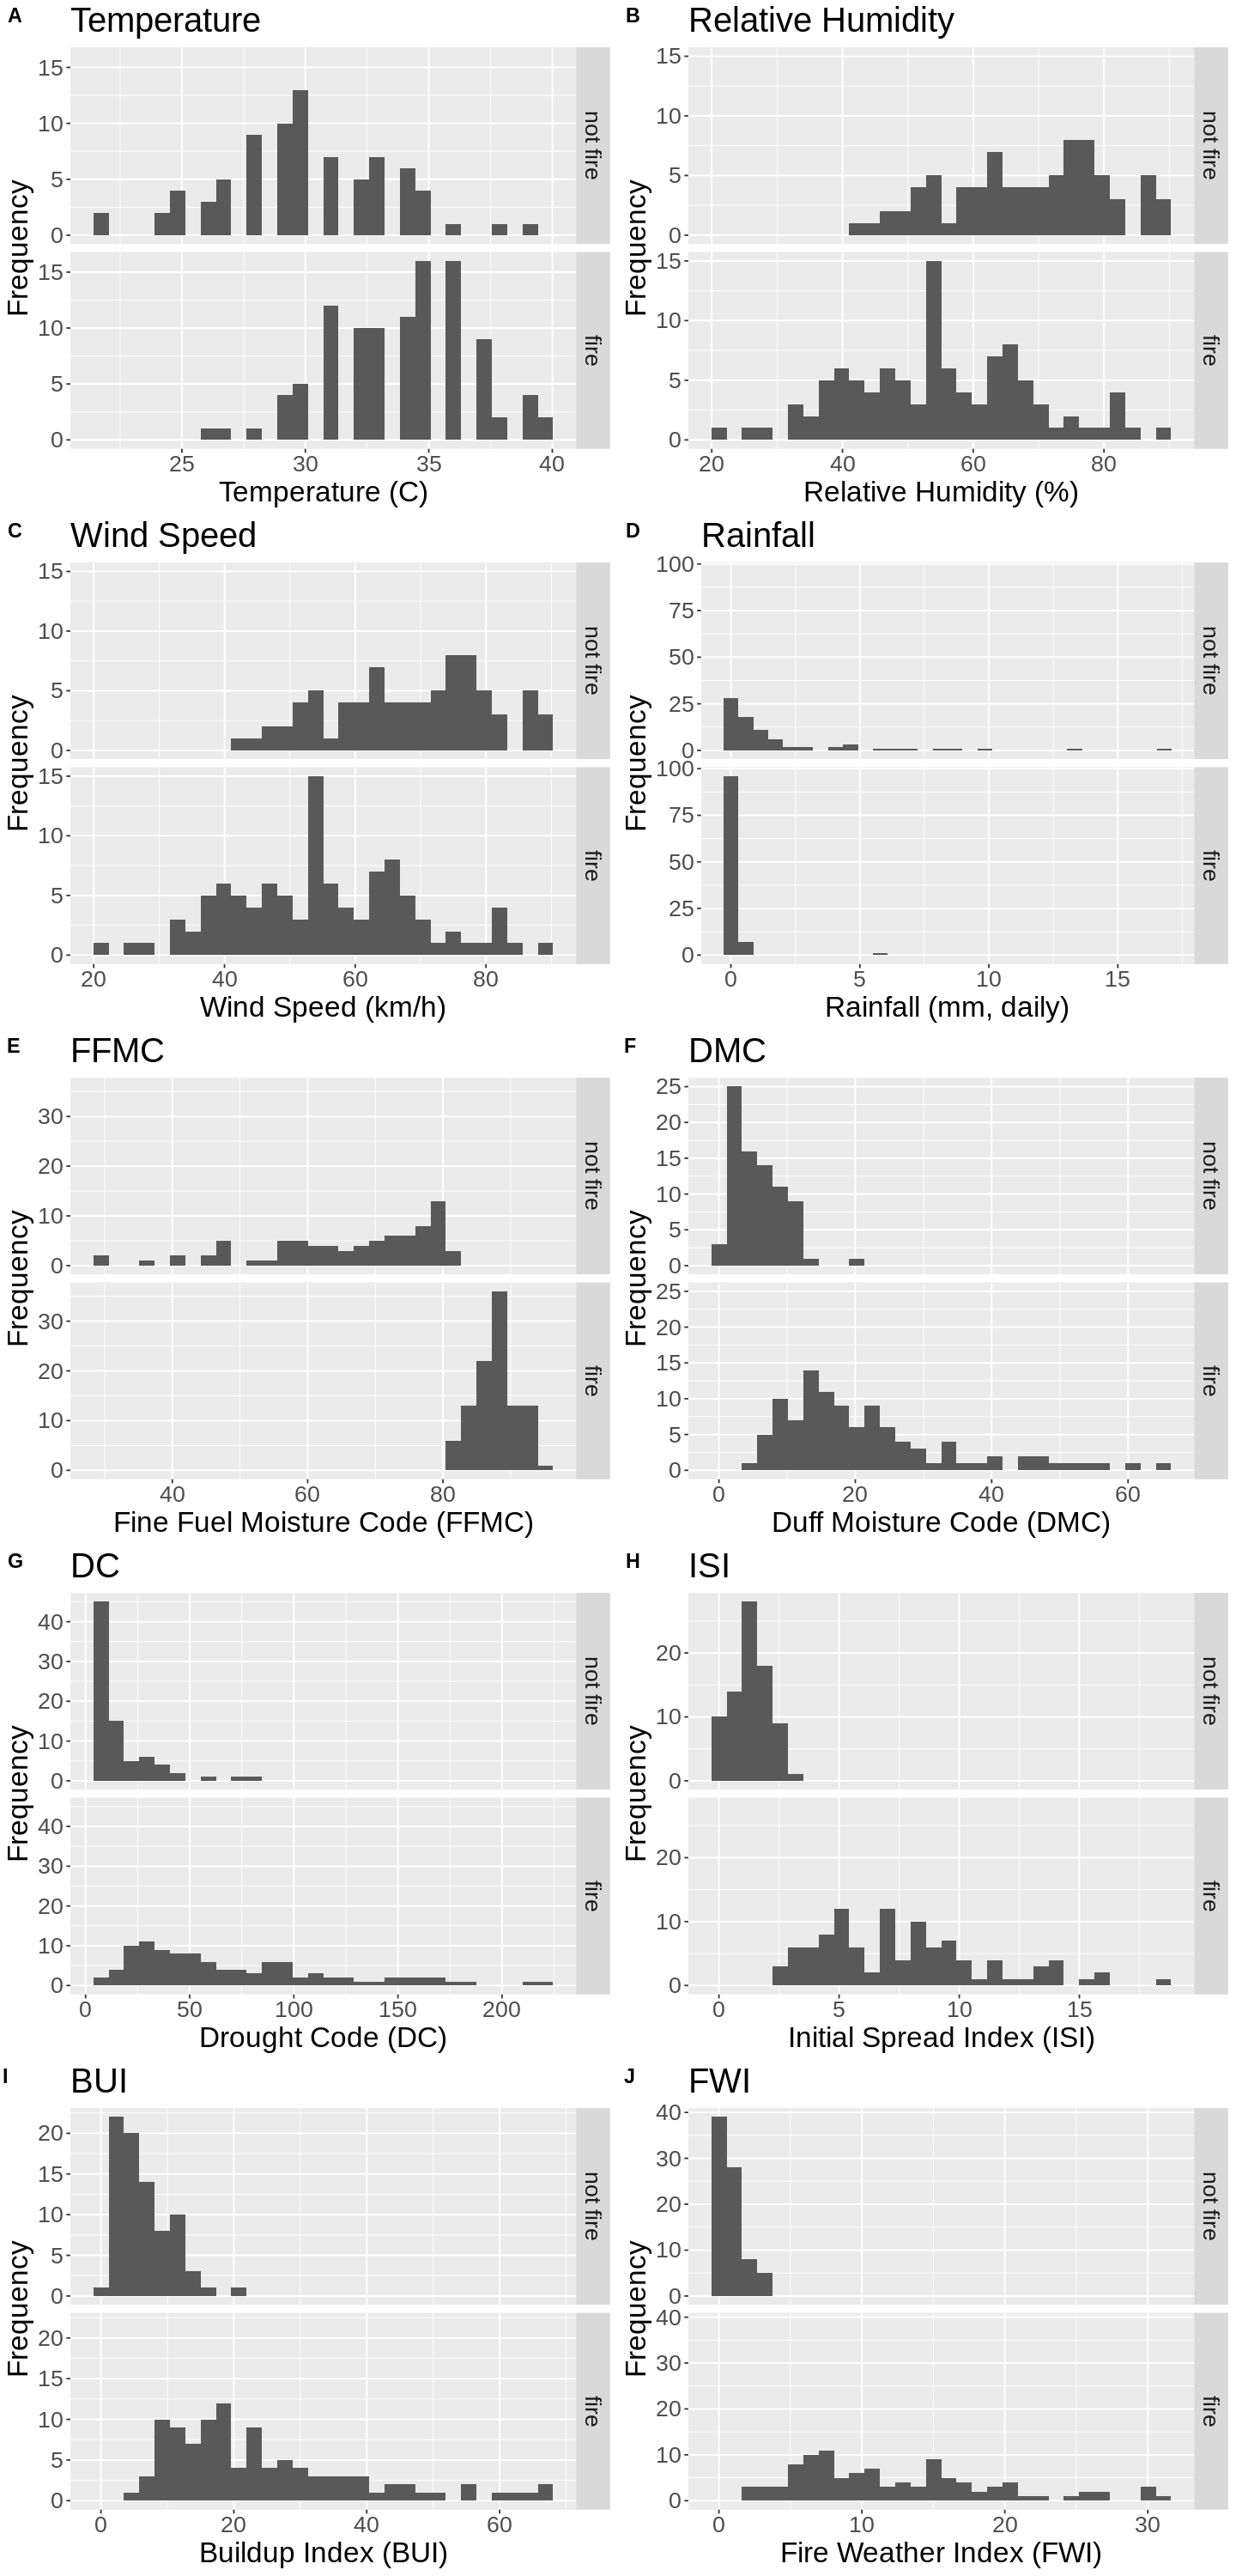

In [69]:
options(repr.plot.width = 12, repr.plot.height = 25)

plot_grid(
  temp_distribution, RH_distribution, WS_distribution, rain_distribution, FFMC_distribution, DMC_distribution, DC_distribution, ISI_distribution, BUI_distribution, FWI_distribution,
  labels = "AUTO", ncol = 2
)

*Figure 1: Histograms of the distributions of the fire and non-fire values of each of the numerical variables in the training dataset*

Visual inspection indicates that FFMC, ISI, BUI and FWI, which have the least amount of overlap between the fire and non-fire distributions, are the best predictors of a fire. Therefore, these four variables were chosen as predictors in the classification algorithm. We would expect that days with fire generally have FFMC greater than 80, ISI greater than 2.5, BUI greater than 10, and FWI greater than 3. Given how clear the distinction is on all the predictor variables and days with and without fire, we expect that the final model would have a relatively high accuracy.

The following table summarizes the means of the chosen predictors and the number of observations for each of the classes. FFMC, ISI, BUI, and FWI are all higher, on average, on days with fire. The class distribution is close to equal, with 104 fire observations and 80 non-fire observations, which suggests there is no imbalance problem with this training dataset.

In [72]:
## Explore means of predictor variables and the number of observations in each category

means <- forest_fire_train %>%
    group_by(Classes) %>%
    summarize(mean_FFMC = mean(FFMC),
             mean_ISI = mean(ISI),
             mean_BUI = mean(BUI),
             mean_FWI = mean(FWI),
             obs_count = n(),
             proportion = obs_count / nrow(forest_fire_train))

means

`summarise()` ungrouping output (override with `.groups` argument)



Classes,mean_FFMC,mean_ISI,mean_BUI,mean_FWI,obs_count,proportion
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
not fire,64.81375,1.261250,6.66250,0.87875,80,0.4347826
fire,87.80096,7.689423,24.40769,12.15481,104,0.5652174


*Table 2: Summary table of the predictor varibales in the training dataset, including mean fire and non-fire values of FFMC, ISI, BUI, and FWI, count of fire and non-fire observations, and the overall proportion of the fire and non-fire observations within the training dataset*

### Classification Model

A k-nearest neighbours classification algorithm with cross-validation was used to create a model to predict whether there will be a fire on a given day. The training data was prepared by using the “recipe” function, specifying the target and predictor variables. Then, the predictor variables were centred and scaled. It is necessary to standardize the data in a k-nearest neighbours algorithm, because rectangular distance is used to determine the similarity between points. Variables that have large scales will thus have more impact on the distance calculation, and so, the algorithm may not accurately determine the true proximity between two observations if scaling is not done. 

Subsequently, the specifications of the k-nearest neighbour classification model with cross-validation were established. This algorithm assumes that similar things exist in close proximity. It classifies an observation by computing the Euclidean distance between the observation and the datapoints in the training dataset, finding the closest k points to the given observation, and classifying it based upon the majority class of the nearest neighbours. To determine the best value of k to use in the model, the neighbours argument was set to “tune(),” to be used with cross-validation. 

 A cross-validation with ten folds was created to find the best value of k. Cross-validation divides the training set of data into equally-sized subsets. For every value of k, each subset is iteratively used as a validation set to compute the accuracy, while the remaining subsets are used as training data. The accuracy of applying the model to each fold for each k is averaged, and this information can then be used to determine the best value for k. Traditionally, cross-validation involves either five or ten folds. Ten folds was chosen because the dataset with which we are working is quite small, and will not be computationally intensive. Moreover, a larger number of folds results in an accuracy estimate with lower standard error.

Subsequently, a k-nearest neighbour model with cross-validation was created by adding the model recipe and specification to a workflow. The model was then trained with cross-validation with 12 different values of k using the tune_grid function. 

In [46]:
fire_recipe <- recipe(Classes ~ FFMC + ISI + BUI + FWI, data = forest_fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

fire_vfold <- vfold_cv(forest_fire_train, v = 10, strata = Classes)

tuning_results <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_tune_spec) %>%
    tune_grid(resamples = fire_vfold, grid = 15) %>%
    collect_metrics()

accuracies <- tuning_results %>%
    filter(.metric == "accuracy")

The metrics from the cross-validation were collected, and subsequently, the average accuracy for each k was plotted to determine the best value of k.


In [47]:
options(repr.plot.width = 8, repr.plot.height = 6)

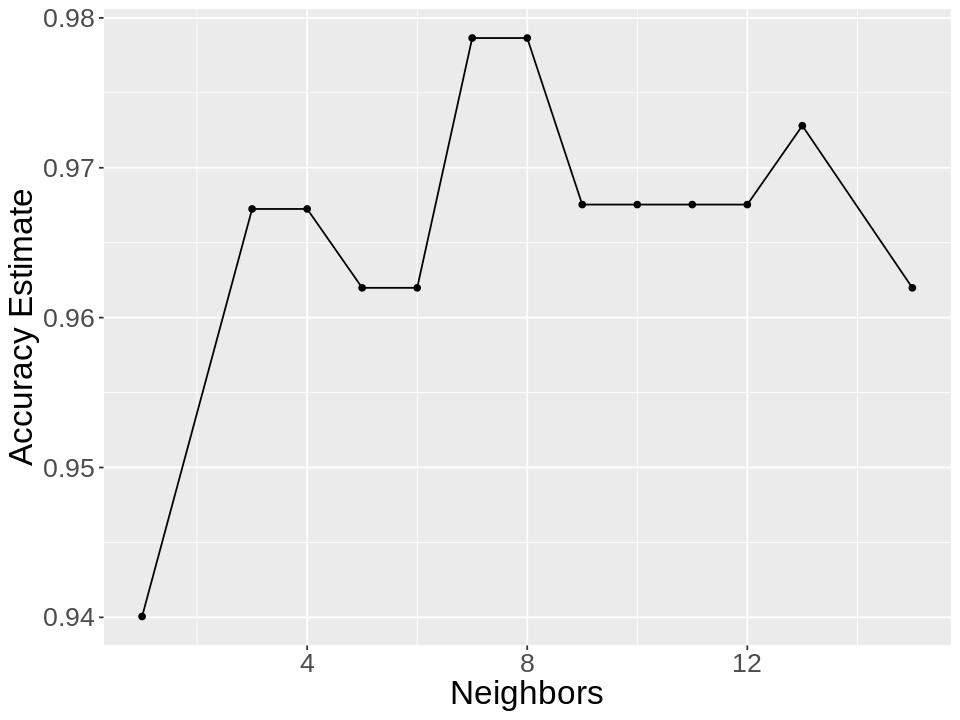

In [48]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20))
accuracy_vs_k

*Figure 2: A plot of the number of neighbours vs. the accuracy estimate from the cross-validation. Seven and eight neighbours appear to build the most accurate models*

The k-values with the highest accuracy in the cross-validation appear to be seven and eight. A k-value of seven was chosen for the model to ensure that there is always a majority class when classifying an observation. 

In [73]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
  set_engine("kknn") %>%
  set_mode("classification")

fire_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = forest_fire_train)


Once the model was fitted, the accuracy of the model was computed by using the predict function to predict the classes of the testing data, and subsequently compare the estimated classes to the true classes.

In [74]:
fire_test_predictions <- fire_fit %>%
    predict(forest_fire_test) %>%
    bind_cols(forest_fire_test)

fire_results <- fire_test_predictions %>%
    metrics(estimate = .pred_class, truth = Classes) %>%
    filter(.metric == accuracy)

fire_results

ERROR: Error: Problem with `filter()` input `..1`.
[31m✖[39m comparison (1) is possible only for atomic and list types
[34mℹ[39m Input `..1` is `.metric == accuracy`.


The model was found to be 96.67% accurate on the testing data; therefore, the model is estimated to correctly predict whether there is going to be a fire on a given day with 98.67% accuracy.

In [51]:
balance <- fire_test_predictions %>%
      conf_mat(truth = Classes, estimate = .pred_class)
balance

          Truth
Prediction not fire fire
  not fire       25    1
  fire            1   33

## Discussion

Before beginning this analysis, we expected that boundaries between classes would occur at around FFMC greater than 80, ISI greater than 2.5, BUI greater than 10, and FWI greater than 3. To evaluate our results, we constructed histograms of the distribution of the predictor variables in the testing set, divided by their predicted class, and compared them to corresponding distributions in the training set when divided by actual classes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



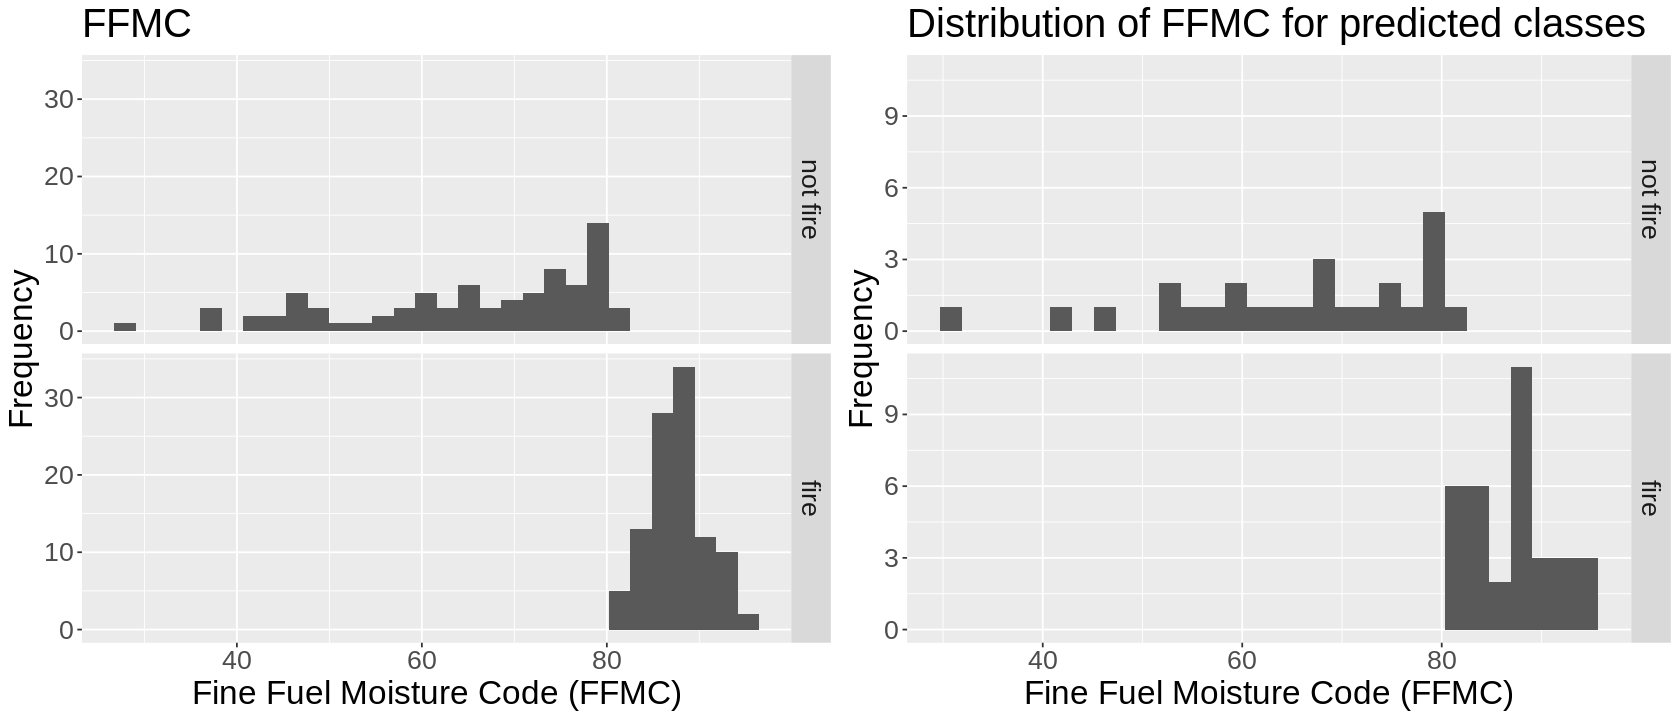

In [52]:
options(repr.plot.width = 14, repr.plot.height = 6)

predicted_FFMC_dist <- ggplot(fire_test_predictions, aes(x = FFMC)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Frequency", title = "Distribution of FFMC for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(FFMC_distribution, predicted_FFMC_dist, ncol = 2)

Based on the distribution of FFMC for each predicted class, the finished KNN model classifies unseen observations with FFMC > 80 as cases of fire, which agrees with our expectation and observed patterns in the training set. In the Fire Weather Index system, the FFMC quantifies the ease of fire ignition under current bioclimatic conditions (De Groot, 1987); it therefore makes sense that a sufficiently high FFMC is related to an actual occurrence of fire.

The classification results appear more mixed when FFMC is close to 80. Since we would also expect uncertainty in real life when conditions are only somewhat conducive to fire ignition, this seems acceptable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



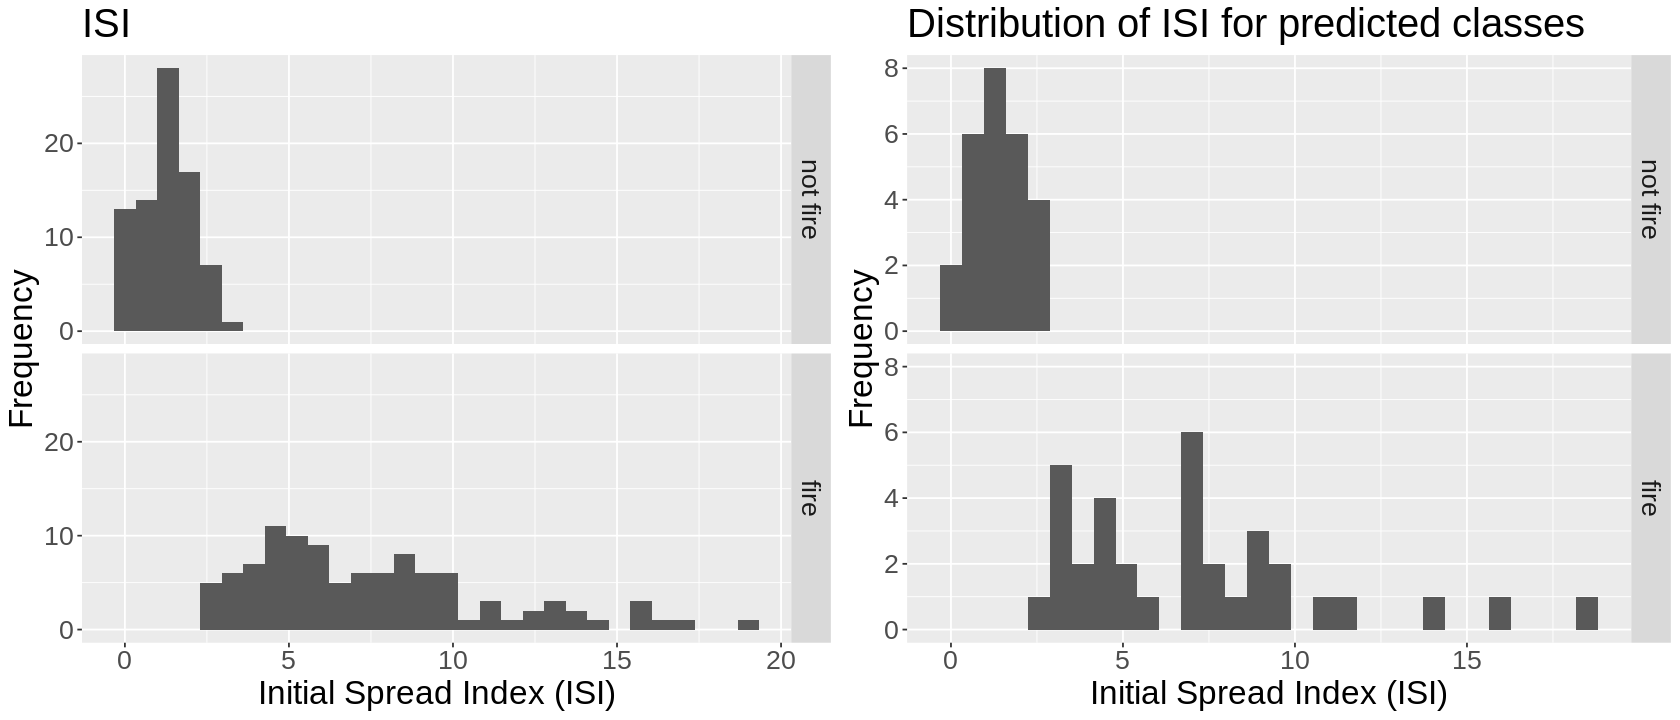

In [53]:
predicted_ISI_dist <- ggplot(fire_test_predictions, aes(x = ISI)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Initial Spread Index (ISI)", y = "Frequency", title = "Distribution of ISI for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(ISI_distribution, predicted_ISI_dist, ncol = 2)

The range of Initial Spread Index for observations classified as fire versus not fire is similar to the range of ISI separated by actual classes in the training set. We would expect an accurate model to classify observations with sufficiently high ISI as cases of fire, given that the ISI estimates the fire spread rate and therefore affects whether a fire is able to grow under current conditions (De Groot, 1987). Indeed, our model generally classifies observations with an ISI > 3 as fire.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



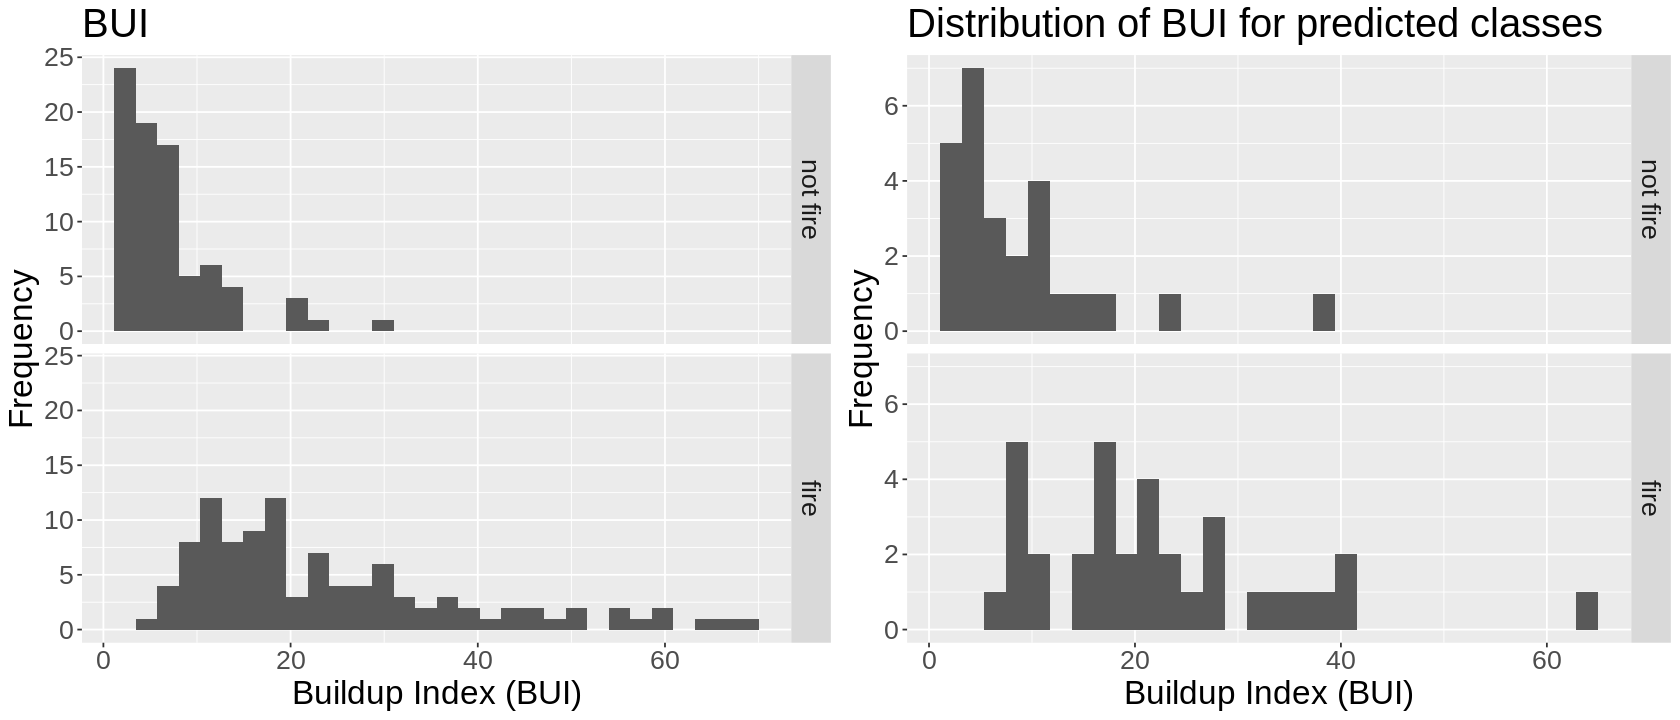

In [54]:
predicted_BUI_dist <- ggplot(fire_test_predictions, aes(x = BUI)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Buildup Index (BUI)", y = "Frequency", title = "Distribution of BUI for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(BUI_distribution, predicted_BUI_dist, ncol = 2)

The Buildup Index estimates the amount of fuel available to a fire, aggregating the moisture levels in the soil layers 5-20 cm deep (De Groot, 1987). The histogram above agrees with our expectation that high BUI would correspond to a case of fire, since it indicates a greater quantity of fuel to support a fire. In practice, however, observations with BUI between 5 and 20 have been classified as both fire and not fire; we may hypothesize that in these ambiguous situations, other predictor variables governed the classifier's decision.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



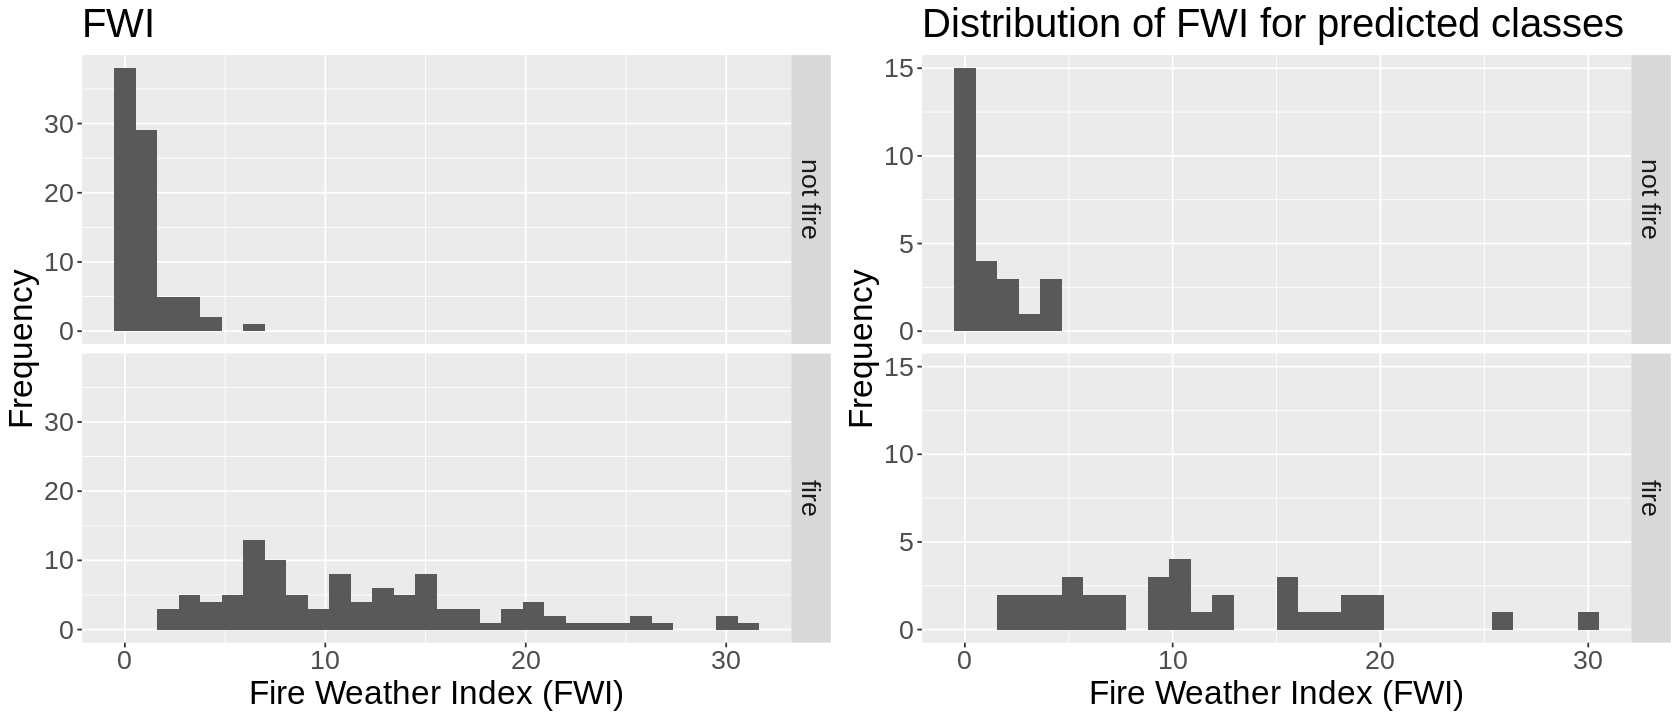

In [55]:
predicted_FWI_dist <- ggplot(fire_test_predictions, aes(x = FWI)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Fire Weather Index (FWI)", y = "Frequency", title = "Distribution of FWI for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(FWI_distribution, predicted_FWI_dist, ncol = 2)

The distributions of FWI for the true and predicted classes are also similar in shape. FWI summarizes the intensity of a potential fire and is one metric for fire risk (De Groot, 1987), with higher FWI corresponding to higher risk. Indeed, in the common case where FWI is 0, the classifier predicted no fire, and nearly all observations with FWI higher than 3 were classified as fire.

Overall, the accuracy of the classifier was estimated at 96.67% on testing data with 61 observations; in other words, 2 observations in the test set were classified incorrectly. In real-life applications of the classifier, a 96.67% accuracy seems sufficient to determine when to organize interventions to prevent forest fires. At the very least, the classifier's results could provide a reasonable assessment of fire risk. Furthermore, this accuracy may be close to the best we can achieve; given the complexity of the environmental conditions that lead to forest fires, it would be impossible to create a perfectly accurate classifier.

Previous studies have found that fire suppression strategies are not enough to address and control fire incidents in Algeria - preventative measures must also be taken (Meddour-Sahar, 2014). Agricultural burning has also been found to be a principal cause of wildfires (Aini et. al., 2019). The classification model that has been developed can be used as a tool to prevent fires. The model can predict whether a wildfire will happen based upon the bioclimatic conditions, and farmers can be advised on whether it is safe to do a burn of their cultivated lands.

Furthermore, the causes of forest fires in Algeria are largely unknown, with 85% of fires in 2020 having unknown causes (Pons, 2020). Our data analysis could lead to asking whether values over a certain threshold of FFMC, ISI, BUI, FWI directly lead to fire incidence.

It may also be beneficial to repeat this analysis with additional data. Since the initial dataset, at 244 observations, was not extremely large, both our accuracy estimate and classifier could be improved by increasing the dataset size.

## References

Aini, A., Curt, T., Bekdouche, F. (2020). Modelling fire hazard in the southern Mediterranean fire rim (Bejaia region, northern Algeria). Retrieved March 03, 2021, from
https://link.springer.com/article/10.1007/s10661-019-7931-0#Sec1

Curt, T., Aini, A., Dupire, S. (2020). Fire activity in Mediterranean forests (The Algerian case). Retrieved March 03, 2021, from
https://www.mendeley.com/catalogue/0ad59940-c469-388c-8796-0685cacb334f/

De Groot, W. J. (1987, April 2). Interpreting the Canadian Forest Fire Weather Index (FWI) System. Retrieved March 03, 2021, from
http://www.dnr.state.mi.us/WWW/FMD/WEATHER/Reference/FWI_Background.pdf

Faroudja ABID et al. (2019). Predicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithms. Retrieved March 01, 2021, from 
https://archive.ics.uci.edu/ml/machine-learning-databases/00547/

Meddour-Sahar, O. (2014). Wildfires in Algeria: problems and challenges. Retrieved April 10, 2021, from
http://www.sisef.it/iforest/pdf/?id=ifor1279-007

Pons, J. (2020, June 29). Algeria declares land and space war on forest fires. Retrieved March 03, 2021, from https://atalayar.com/en/content/algeria-declares-land-and-space-war-forest-fires